## AAE 625 Fianl Project: Seattle Bicycle Model

Zhiying Chen

## Question: are we really seeing an increase in cycling, or can it just be attributed to good weather?

## Target Audience: 

- Urban planning and transportation departments

## Objective: 
- Provide accurate and reliable predictions of cycling ridership trends in Seattle, taking into account seasonal and climate factors.
- Quantify the impact of each factor on cycling ridership, allowing stakeholders to make data-driven decisions and prioritize initiatives.
- Serve as a tool for monitoring and evaluating the effectiveness of cycling promotion campaigns and infrastructure investments over time.

In [1]:
# Import necessary statements
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

## Examining the Fremont Bridge Data

In [2]:
# Load the data file, and create a column with total north/south traffic
hourly = pd.read_csv("Fremont_Bridge_Bicycle_Counter_20240427.csv", index_col='Date', parse_dates=True, date_format='%m/%d/%Y %I:%M:%S %p')
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']

In [3]:
# Resample the data into daily and weekly totals
daily = hourly.resample('D').sum()
weekly = daily.resample('W').sum()

Noe let's take a peek at our data and see what it looks like.

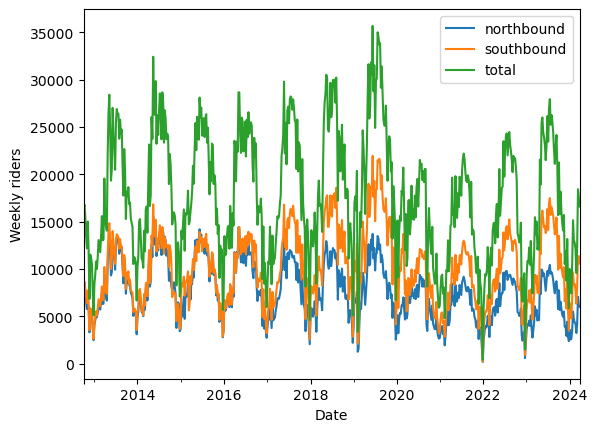

In [4]:
weekly[['northbound', 'southbound', 'total']].plot()
plt.ylabel('Weekly riders');

At first glance, the plot reveals strong seasonal patterns, with bicycle traffic peaking in the summer months and reaching lows in the winter months each year. While 2020 follows the typical seasonal pattern, the peak is noticeably lower compared to previous years, likely reflecting decreased activity during the COVID-19 pandemic. 

Prior to 2017, the northbound and southbound areas were roughly equal, but the divergence becomes quite noticeable in the later years. More cyclists choose the southbound area and "southbound" represents the total number of bicyclists traveling on the East sidewalk in one hour as recorded by the sensor. "The Fremont Bridge’s design, which includes sidewalks as narrow as six feet at key points, makes it difficult to accommodate cyclists and pedestrians, who are forced to share the same two-way pathways while crossing the bridge. While narrow, the Ballard Bridge, the next alternative to the west, is narrower still and notoriously dangerous."(Source: Advocates Push for Bike and Transit Lanes on the Fremont Bridge https://www.theurbanist.org/2020/09/09/advocates-push-for-bike-and-transit-lanes-on-the-fremont-bridge/) The difference in traffic is caused by the fact that the road condition of the western sidewalk is worse than that of the east, and this situation continues to not be improved.

We use a **moving window average**: basically, for each day we'll take the average of the 30-day period around it:

<Axes: xlabel='Date'>

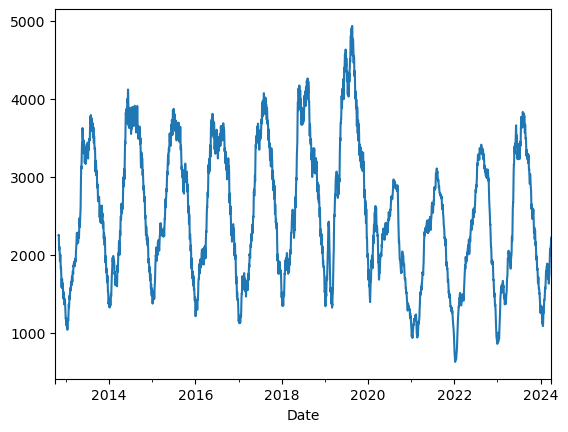

In [5]:
daily['total'].rolling(window = 30).mean().plot()

Each year's peak since 2020 has been slightly higher than the previous year's. As for 2024, while the data does not yet include the peak season, the counts up to April are notably higher compared to the same period in previous years. This suggests that 2024 is on track to continue the trend of increasing seasonal peaks, although we'll need to wait for the full year's data to confirm this.

But it is clear that there is still some seasonal variation. What we're going to try to do below is to **model this variation** based on our intuition about what factors might come into play in people's decision about whether to ride. For simplicity, I'm going to stick with a **linear model** here. 

Obviously, there is a big difference in the annual peak before and after 2020. According to the timeline on the King County Government’s official website, on February 28, 2020, King County had its first confirmed COVID-19 death, which was the first case in the United States. The next day, Governor Inslee issued State of Emergency. On March 13, the state government issued a ban on large-scale events.(Rource: Our COVID-19 response https://kingcounty.gov/en/legacy/elected/executive/constantine/covid-response/covid) It can be seen that Covid-19 has caused people to maintain social distance and reduced people's outing activities. Therefore, in order to reflect the difference before and after the epidemic, I will add a **dummy variable** to the model. Pre-2020 is treated as 0 and post-2020 is treated as 1.

In [6]:
# Load the complete dataset
hourly = pd.read_csv("Fremont_Bridge_Bicycle_Counter.csv", index_col='Date', parse_dates=True, date_format='%m/%d/%Y %I:%M:%S %p')
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']

daily = hourly.resample('D').sum()
weekly = daily.resample('W').sum()

# Create a dummy variable for post-2020
daily['post_2020'] = (daily.index >= '2020-01-01').astype(int) # pre-2020 = 0; post-2020 = 1

## Factor 1: Accounting for hours of daylight

The addition of dummy variable doesn't affect the daylight calculations or the analysis related to daylight hours. The dummy variable is used to capture the overall difference in bicycle traffic between the pre-2020 and post-2020 periods, while the daylight-related features capture the seasonal variations in bicycle traffic due to changes in daylight hours.

In [7]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - datetime.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))

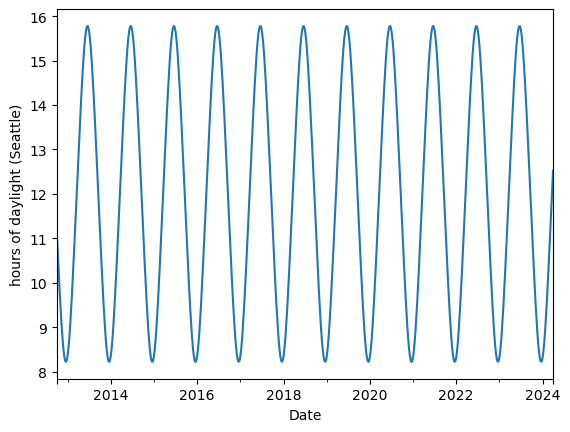

In [8]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Seattle)');

This looks reasonable: just over 8 hours of daylight in December, and just under 16 hours in June.

To get a feel for the trend, let's plot the daylight hours versus the weekly bicycle traffic:

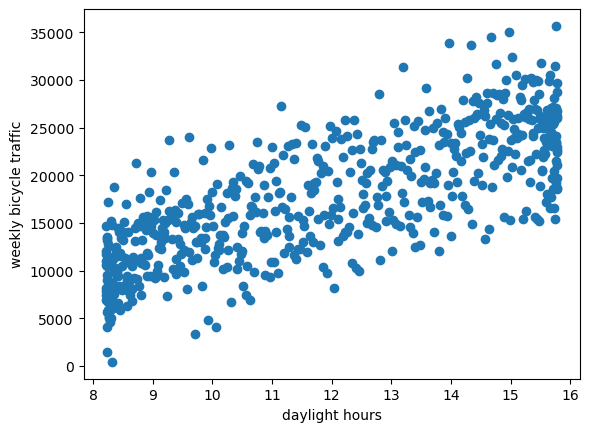

In [9]:
plt.scatter(weekly['daylight'], weekly['total'])
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

We see a clear trend, though it's also apparent from the wide vertical scatter that other effects are at play. Let's apply a linear fit to this data. 

/Users/chenzhiying/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'weekly bicycle traffic')

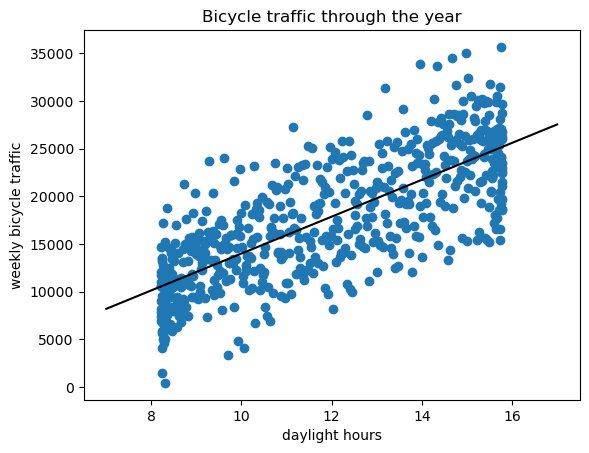

In [10]:
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']]  # Use the 'daylight' column as the feature matrix
y = weekly['total']

clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])

plt.scatter(weekly['daylight'], weekly['total'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic')

In [11]:
print(clf.coef_[0])

1933.981800588765


This tells us that according to this model, each extra hour of daylight leads to about 1900 more riders per week across the bridge. Of course, in Seattle the length of the day also correlates highly with temperature and precipitation; we'll try to untangle those effects later.

/Users/chenzhiying/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'adjusted weekly count')

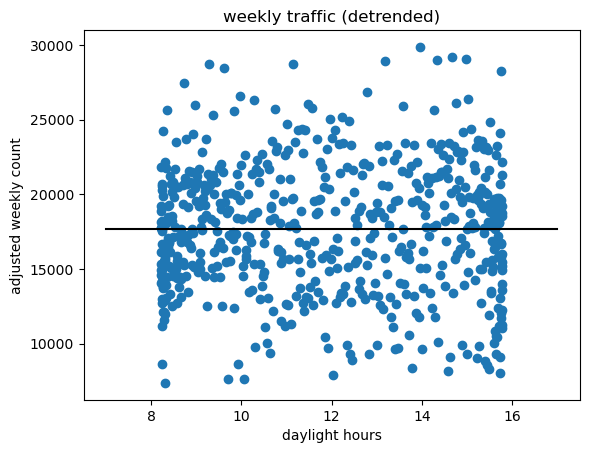

In [12]:
# de-trended data

trend = clf.predict(weekly[['daylight']].to_numpy())

plt.scatter(weekly['daylight'], weekly['total'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count')

We've basically removed the component of the data which correlates with the number of hours in a day, so that what is left is in some way agnostic to this quantity. The "adjusted weekly count" plotted here can be thought of as the number of cyclists we'd expect to see if the hours of daylight were not a factor.

Let's visualize this another way. Instead of plotting the number of riders vs daylight hours, we'll again plot the number of riders vs the day of the year, along with the trend:

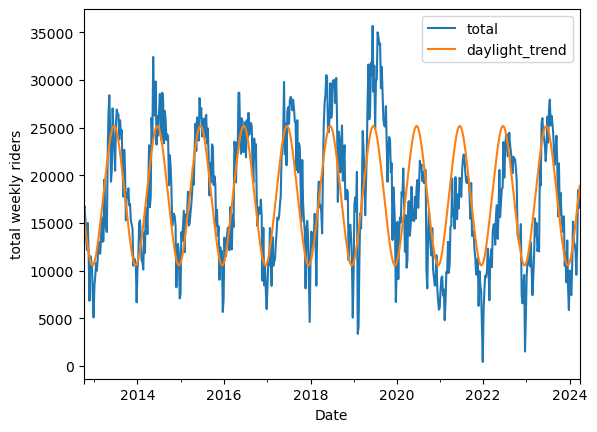

In [13]:
weekly[['total', 'daylight_trend']].plot()
plt.ylabel("total weekly riders");

root-mean-square about trend: 4306 riders


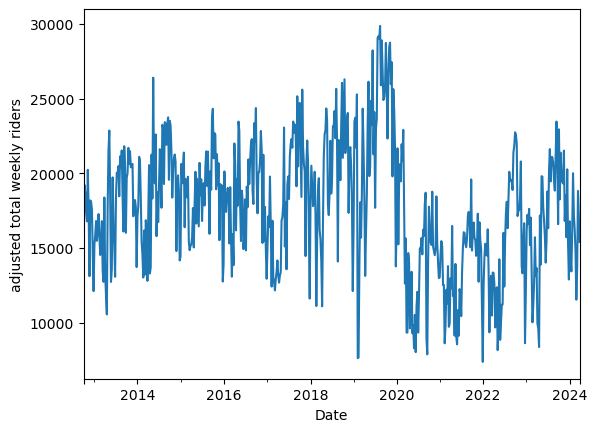

In [14]:
weekly['daylight_corrected_total'].plot()
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders")
print("root-mean-square about trend: {0:.0f} riders".format(rms))

With the data de-trended, we get a better idea of how bicycling in Seattle has changed over time, corrected for the seasonal variation.

## Factor 2: Accounting for Day of the Week

Above we've been looking at weekly data. This is because daily data shows a clear swing as a function of the day of the week, which we'll show here.

In [15]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek

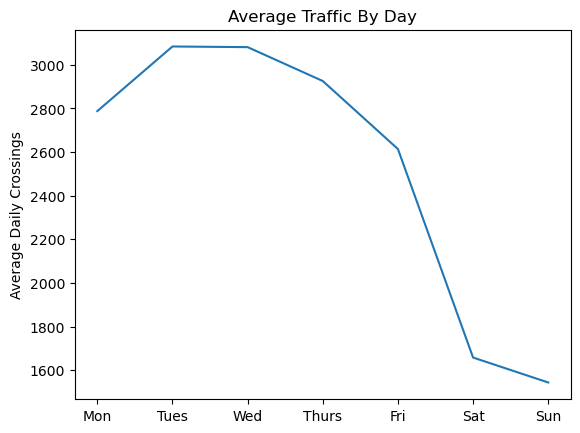

In [16]:
grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

As you might expect in a city of bicycle commuters, there is roughly 3 times the amount of traffic on weekdays as there is on weekends. Bicycles are not just for entertainment! In Seattle, at least, they are a real means of commuting for thousands of people per day, and the data show this clearly.

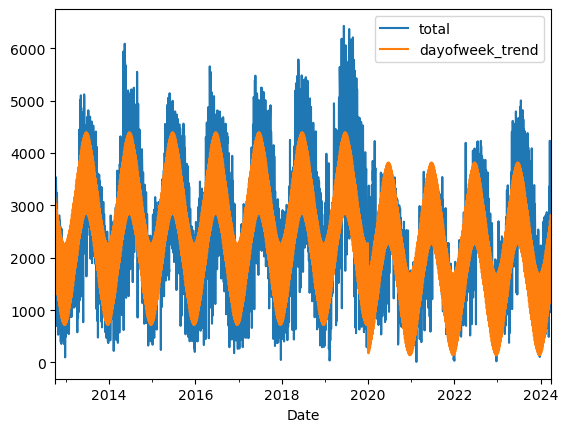

In [17]:
# Add one-hot indicators of weekday
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# de-trend on days of the week and daylight together
X = daily[days + ['daylight', 'post_2020']]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['dayofweek_trend'] = clf.predict(X)
daily[['total', 'dayofweek_trend']].plot();

This shows all the daily bicycle counts (in blue) along with the best-fit trend based on the day of the week and the number of daylight hours per day. It's more clear if we plot the de-trended data:

rms = 808


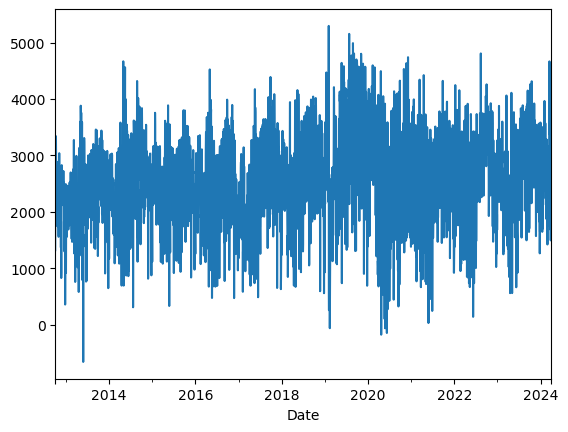

In [18]:
daily['dayofweek_corrected'] = (daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])))
daily['dayofweek_corrected'].plot();

What we're seeing here is the number of bicycle crossings per day, corrected for the daily and annual trends. In other words, this is what we might expect the data to look like if the day of the week and the hours of light per day did not matter.

Let's continue on this line of reasoning, and add some more information to the model.

## Factor 3: Accounting for Temperature and Rainfall

Next we'll account for the NCDC climate data that was described above. The data includes the daily maximum and minimum temperatures, as well as the amount of recorded rainfall at SeaTac airport, about 15 miles to the south. Let's take a look at this data:

In [19]:
# load weather data
weather = pd.read_csv('SeaTacWeather.csv', index_col='DATE', parse_dates=True, usecols=[2,5,9,10])
print(weather.columns)

Index(['PRCP', 'TMAX', 'TMIN'], dtype='object')


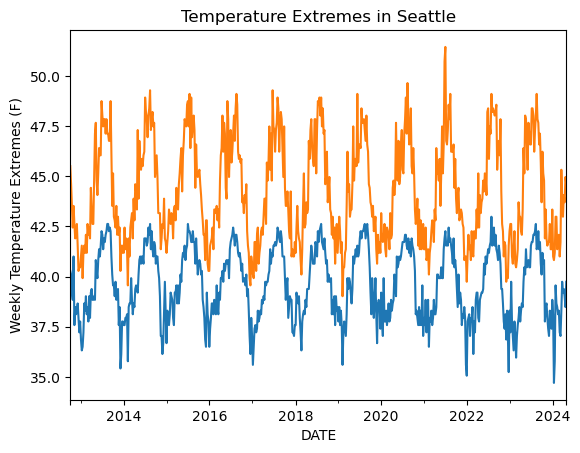

In [20]:
# temperatures are in 1/10 deg C; convert to F
weather['TMIN'] = 0.18 * weather['TMIN'] + 32
weather['TMAX'] = 0.18 * weather['TMAX'] + 32

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254

weather['TMIN'].resample('w').min().plot()
weather['TMAX'].resample('w').max().plot()

plt.ylabel('Weekly Temperature Extremes (F)');
plt.title("Temperature Extremes in Seattle");

This shows the maximum and minimum temperatures in Seattle. 

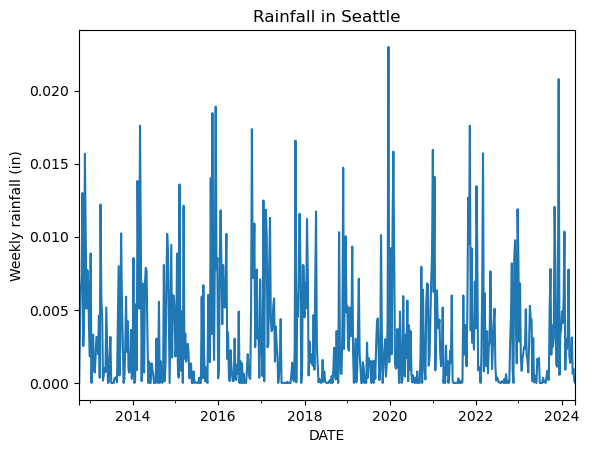

In [21]:
weather['PRCP'].resample('w').sum().plot();
plt.ylabel('Weekly rainfall (in)')
plt.title("Rainfall in Seattle");

The rainfall is also as expected. Almost none in the summer months, and up to about 6 inches per week in the rainiest parts of the year.

What we do next will start to look very familiar: we'll add the climate information to our original daily dataset, and then use a linear model to de-trend the data with this new information.

In [22]:
# join the weather data to our daily data
daily = daily.join(weather)

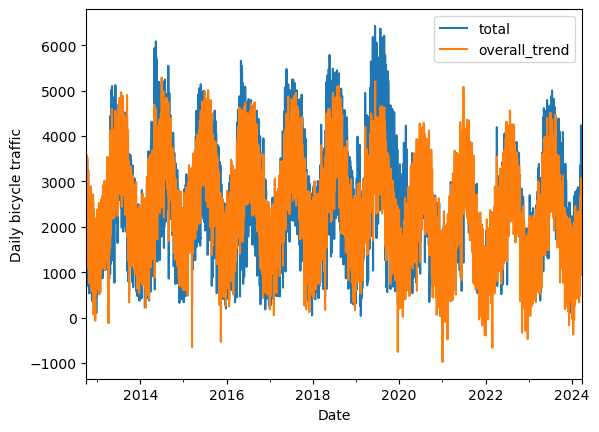

In [23]:
columns = days + ['post_2020', 'daylight', 'TMIN', 'TMAX', 'PRCP']
X = daily[columns]
y = daily['total']

from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_imputed, y)

# Predict the overall trend
daily['overall_trend'] = model.predict(X_imputed)

# Plot the overall trend
daily[['total', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic')
plt.show()

This shows the data along with the overall trend, accounting for precipitation and temperature extremes.

rms = 656


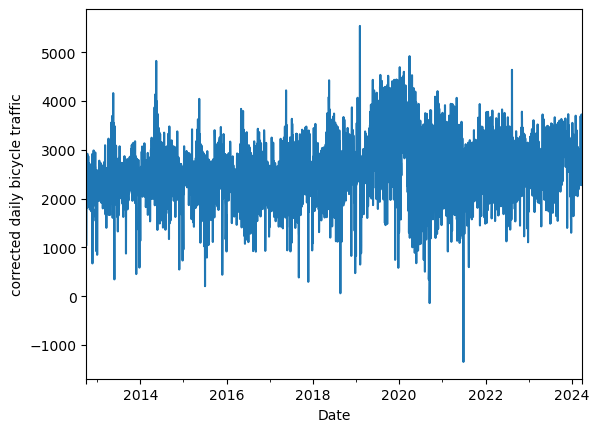

In [24]:
daily['overall_corrected'] = daily['total'] - daily['overall_trend'] + daily['overall_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['overall_corrected'])))
daily['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic');

From the reduced RMS, we can see that our model does a fairly good job capturing the trends. But there's still some daily variation that it cannot account for. We could think about what this might be, and try to capture it with more inputs to the model. For example, a person's choice to ride might be affected not just by the weather today, but by the weather yesterday. We also could account for freezing temperatures, which may manifest as a nonlinear effect.

In order to better see the remaining trend, let's plot a month-long moving-window average over the corrected data:

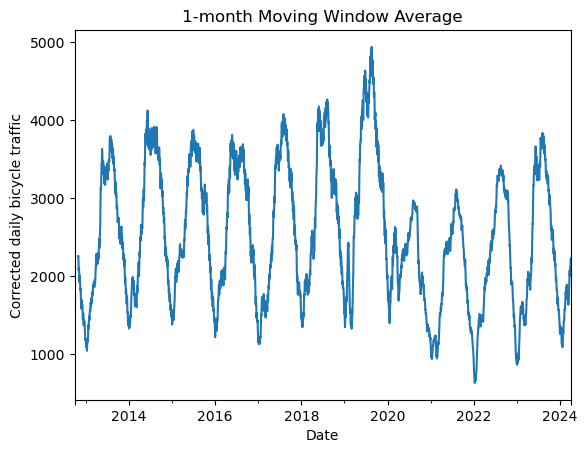

In [25]:
daily['total'].rolling(window=30).mean().plot()
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average');

This is similar to the moving window we used above, exept we are using de-trended data. What we see is that even after correcting for the length of day, the temperature, the precipitation, and the weekly trends, we still see a trend of increasing peaks each year.

We noticed that the detrended data hits a low-point in Jan 2022. This does not mean there were fewer riders in that month, but that there were fewer riders than the model would expect given the weather, hours of daylight, and day of the week. This points to the existence of other factors that we've not taken into account. Perhaps the average weather in a given time period affects people's decisions: that is, a warm day in January brings everyone out, while a warm day in July is so unexceptional that people leave their bike in the garage. It would be interesting to do a more detailed analysis and try to eke-out this type of information.

Nevertheless, if you look at this plot and squint, you can also see what looks like a steady upward trend from left to right. Let's see if we can quantify this.

## Fianl model: Accounting for a Steady Increase or Decrease of Riders

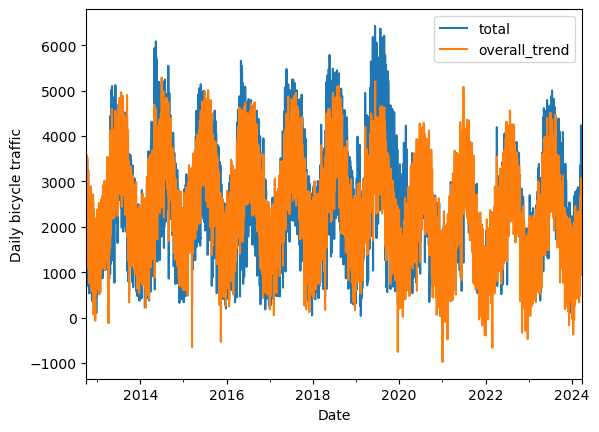

In [26]:
columns = days + ['post_2020', 'daylight', 'TMIN', 'TMAX', 'PRCP']  # Add 'post_2020' to the columns
X = daily[columns]
y = daily['total']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_imputed, y)

# Predict the overall trend
daily['overall_trend'] = model.predict(X_imputed)

# Plot the overall trend
daily[['total', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic')
plt.show()

In [27]:
daily['daycount'] = np.arange(len(daily))

columns = days + ['post_2020', 'daycount', 'daylight', 'TMIN', 'TMAX', 'PRCP']  # Add 'post_2020' and 'daycount' to the columns
X = daily[columns]
y = daily['total']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Create a linear regression model as the final model
final_model = LinearRegression()

# Fit the final model
final_model.fit(X_imputed, y)

# Predict the final trend
daily['final_trend'] = final_model.predict(X_imputed)

daily['final_corrected'] = daily['total'] - daily['final_trend'] + daily['final_trend'].mean()

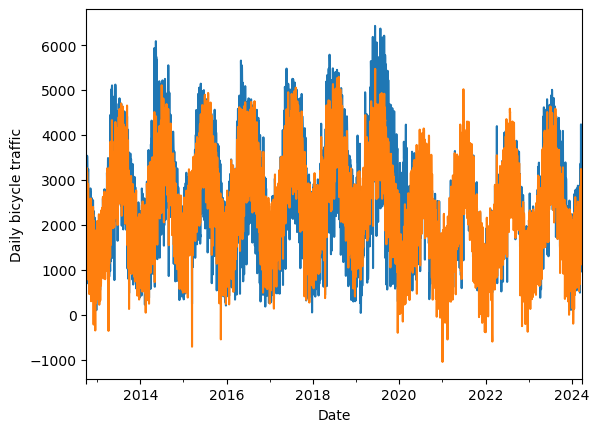

In [28]:
daily['total'].plot()
daily['final_trend'].plot()
plt.ylabel('Daily bicycle traffic')
plt.show()

RMS = 636


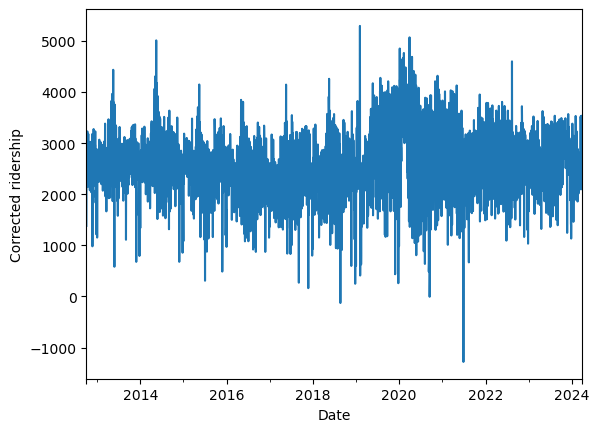

In [29]:
# De-trended data
daily['final_corrected'].plot()
plt.ylabel('Corrected ridership')
print("RMS = {0:.0f}".format(np.std(daily['final_corrected'])))

## What Can The Final Model Tell Us?

Now that we have this model, we can use it to answer some questions about bike ridership in Seattle.

First we'll compute the error covariance, which contains the error bars on each of the parameters:

In [30]:
# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the input features and transform the data
X_imputed = imputer.fit_transform(X)

# Fit the linear regression model on the imputed data
model = LinearRegression()
model.fit(X_imputed, y)

# Get the coefficient estimates
coefficients = np.concatenate([model.coef_, [model.intercept_]])

# Calculate the residuals
residuals = y - model.predict(X_imputed)

# Calculate the residual variance
residual_variance = np.sum(residuals ** 2) / (len(y) - len(coefficients))

# Calculate the covariance matrix of the coefficient estimates
X2 = np.hstack([X_imputed, np.ones((X_imputed.shape[0], 1))])
cov_matrix = residual_variance * np.linalg.inv(np.dot(X2.T, X2))

# Calculate the standard errors of the coefficient estimates
std_errors = np.sqrt(np.diag(cov_matrix))

# Print the coefficient estimates and their standard errors
for i, col in enumerate(columns + ['intercept']):
    coef = coefficients[i]
    std_error = std_errors[i]
    print(f"{col}: coefficient = {coef:.2f}, standard error = {std_error:.2f}")

Mon: coefficient = 246.61, standard error = 844472035.79
Tues: coefficient = 551.04, standard error = 844472035.79
Wed: coefficient = 537.33, standard error = 844472035.79
Thurs: coefficient = 398.76, standard error = 844472035.79
Fri: coefficient = 94.02, standard error = 844472035.79
Sat: coefficient = -842.20, standard error = 844472035.79
Sun: coefficient = -985.57, standard error = 844472035.79
post_2020: coefficient = -1059.42, standard error = 37.18
daycount: coefficient = 0.24, standard error = 0.01
daylight: coefficient = 91.95, standard error = 5.98
TMIN: coefficient = -126.98, standard error = 13.44
TMAX: coefficient = 313.85, standard error = 10.16
PRCP: coefficient = -221969.01, standard error = 10397.53
intercept: coefficient = -6962.31, standard error = 844472035.79


The standard errors are extremely large, especially for the day of the week variables (e.g., 'Mon', 'Tues', etc.) and the intercept term. 

Then, I divide the data into two groups: one for **working days** (including Monday to Friday) and the other for **weekends** (including Saturday and Sunday). This can help reduce the multicollinearity issues that may arise from having separate variables for each day of the week.

In [31]:
from sklearn.metrics import mean_squared_error

# Create a new column 'is_weekend' to indicate if a day is a weekend or not
daily['is_weekend'] = daily.index.dayofweek.isin([5, 6]).astype(int)

# Update the columns list to include 'is_weekend' and remove individual day columns
columns = ['is_weekend', 'post_2020', 'daycount', 'daylight', 'TMIN', 'TMAX', 'PRCP']

# Select the updated columns from the daily DataFrame
X = daily[columns]

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Add a column of ones for the intercept term
X2 = np.hstack([X_imputed, np.ones((X_imputed.shape[0], 1))])

# Create an instance of the LinearRegression class
model = LinearRegression()

# Fit the model
model.fit(X2, y)

# Predict the target variable
y_pred = model.predict(X2)

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred)

# Calculate the error covariance matrix
n_samples = X2.shape[0]
n_features = X2.shape[1]
dof = n_samples - n_features
sigma2 = mse * dof / (n_samples - 1)
error_cov = sigma2 * np.linalg.inv(np.dot(X2.T, X2))

# Extract the standard errors (error bars) for each parameter
std_errors = np.sqrt(np.diag(error_cov))

# Print the coefficients and their standard errors
for i, col in enumerate(columns + ['intercept']):
    coef = model.coef_[i] if i < n_features - 1 else model.intercept_
    std_error = std_errors[i]
    print(f"{col}: coefficient = {coef:.2f}, standard error = {std_error:.2f}")

is_weekend: coefficient = -1279.43, standard error = 22.31
post_2020: coefficient = -1059.23, standard error = 38.14
daycount: coefficient = 0.24, standard error = 0.02
daylight: coefficient = 91.91, standard error = 6.13
TMIN: coefficient = -128.88, standard error = 13.78
TMAX: coefficient = 315.10, standard error = 10.41
PRCP: coefficient = -221964.25, standard error = 10661.05
intercept: coefficient = -6572.62, standard error = 305.64


The coefficient for 'is_weekend' will represent the average difference in bicycle traffic between weekends and working days. It represents on average, there will be 1300 fewer cyclists on weekends than on weekdays. People mainly use this road for commuting.

## How Does Rain Affect Ridership on weekdays and weekends?

In [32]:
from sklearn.preprocessing import StandardScaler

# Create an interaction term between 'is_weekend' and 'PRCP'
daily['is_weekend_PRCP'] = daily['is_weekend'] * daily['PRCP']

# Update the columns list to include relevant features and the interaction term
columns = ['post_2020', 'daycount', 'daylight', 'TMIN', 'TMAX', 'PRCP', 'is_weekend', 'is_weekend_PRCP']

# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the input features and transform the data
X_imputed = imputer.fit_transform(daily[columns])

# Create a scaler object to standardize the features
scaler = StandardScaler()

# Fit the scaler on the imputed data and transform the features
X_scaled = scaler.fit_transform(X_imputed)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the scaled data
model.fit(X_scaled, daily['total'])

# Get the index of the 'PRCP' and 'is_weekend_PRCP' features in the columns list
prcp_ind = columns.index('PRCP')
is_weekend_prcp_ind = columns.index('is_weekend_PRCP')

# Get the coefficients for 'PRCP' and 'is_weekend_PRCP'
prcp_coef = model.coef_[prcp_ind]
is_weekend_prcp_coef = model.coef_[is_weekend_prcp_ind]

# Calculate the standard errors of the coefficients
n_samples = X_scaled.shape[0]
n_features = X_scaled.shape[1]
dof = n_samples - n_features
mse = np.mean((model.predict(X_scaled) - daily['total']) ** 2)
sigma2 = mse * dof / (n_samples - 1)
error_cov = sigma2 * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
prcp_error = np.sqrt(error_cov[prcp_ind, prcp_ind])
is_weekend_prcp_error = np.sqrt(error_cov[is_weekend_prcp_ind, is_weekend_prcp_ind])

print("Weekdays: {0:.2f} +/- {1:.2f} daily crossings lost per standard deviation increase in rain".format(-prcp_coef, prcp_error))
print("Weekends: {0:.2f} +/- {1:.2f} daily crossings lost per standard deviation increase in rain".format(-(prcp_coef + is_weekend_prcp_coef), np.sqrt(prcp_error**2 + is_weekend_prcp_error**2)))

Weekdays: 247.60 +/- 12.51 daily crossings lost per standard deviation increase in rain
Weekends: 203.47 +/- 17.84 daily crossings lost per standard deviation increase in rain


The impact of rainfall on daily crossings is more pronounced during weekdays compared to weekends. A one standard deviation increase in rainfall leads to a larger decrease in daily crossings on weekdays than on weekends.

## How Does Temperature Affect Ridership on workdays and weekends?

For temperature, we have to be more careful. The minimum and maximum temperature will be highly correlated, so we should average the trends between the two:

In [33]:
# Create interaction terms between 'is_weekend' and temperature features
daily['is_weekend_TMIN'] = daily['is_weekend'] * daily['TMIN']
daily['is_weekend_TMAX'] = daily['is_weekend'] * daily['TMAX']

# Update the columns list to include relevant features and interaction terms
columns = ['post_2020', 'daycount', 'daylight', 'PRCP', 'TMIN', 'TMAX', 'is_weekend', 'is_weekend_TMIN', 'is_weekend_TMAX']

# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the input features and transform the data
X_imputed = imputer.fit_transform(daily[columns])

# Create a scaler object to standardize the features
scaler = StandardScaler()

# Fit the scaler on the imputed data and transform the features
X_scaled = scaler.fit_transform(X_imputed)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the scaled data
model.fit(X_scaled, daily['total'])

# Get the index of the temperature features and interaction terms
tmin_ind = columns.index('TMIN')
tmax_ind = columns.index('TMAX')
is_weekend_tmin_ind = columns.index('is_weekend_TMIN')
is_weekend_tmax_ind = columns.index('is_weekend_TMAX')

# Calculate the average effect of temperature on workdays
workday_effect = (model.coef_[tmin_ind] + model.coef_[tmax_ind]) / 2

# Calculate the average effect of temperature on weekends
weekend_effect = (model.coef_[tmin_ind] + model.coef_[is_weekend_tmin_ind] + model.coef_[tmax_ind] + model.coef_[is_weekend_tmax_ind]) / 2

# Calculate the standard errors of the effects
n_samples = X_scaled.shape[0]
n_features = X_scaled.shape[1]
dof = n_samples - n_features
mse = np.mean((model.predict(X_scaled) - daily['total']) ** 2)
sigma2 = mse * dof / (n_samples - 1)
error_cov = sigma2 * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
workday_error = np.sqrt((error_cov[tmin_ind, tmin_ind] + error_cov[tmax_ind, tmax_ind] + 2 * error_cov[tmin_ind, tmax_ind]) / 4)
weekend_error = np.sqrt((error_cov[tmin_ind, tmin_ind] + error_cov[is_weekend_tmin_ind, is_weekend_tmin_ind] + error_cov[tmax_ind, tmax_ind] + error_cov[is_weekend_tmax_ind, is_weekend_tmax_ind] + 2 * (error_cov[tmin_ind, is_weekend_tmin_ind] + error_cov[tmin_ind, tmax_ind] + error_cov[tmin_ind, is_weekend_tmax_ind] + error_cov[is_weekend_tmin_ind, tmax_ind] + error_cov[is_weekend_tmin_ind, is_weekend_tmax_ind] + error_cov[tmax_ind, is_weekend_tmax_ind])) / 4)

print("Workdays: {0:.2f} +/- {1:.2f} daily crossings per standard deviation increase in temperature".format(workday_effect, workday_error))
print("Weekends: {0:.2f} +/- {1:.2f} daily crossings per standard deviation increase in temperature".format(weekend_effect, weekend_error))

Workdays: 313.88 +/- 8.59 daily crossings per standard deviation increase in temperature
Weekends: -989.72 +/- 124.27 daily crossings per standard deviation increase in temperature


During workdays, an increase in temperature is associated with an increase in daily crossings. However, during weekends, an increase in temperature is associated with a decrease in daily crossings. 

Also, the standard error for the weekend estimate is much larger than the standard error for the workday estimate, indicating greater uncertainty in the weekend estimate.

## How Does Daylight Affect Ridership on workdays and weekends?

In [34]:
# Create an interaction term between 'is_weekend' and 'daylight'
daily['is_weekend_daylight'] = daily['is_weekend'] * daily['daylight']

# Update the columns list to include relevant features and the interaction term
columns = ['post_2020', 'daycount', 'daylight', 'PRCP', 'TMIN', 'TMAX', 'is_weekend', 'is_weekend_daylight']

# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the input features and transform the data
X_imputed = imputer.fit_transform(daily[columns])

# Create a scaler object to standardize the features
scaler = StandardScaler()

# Fit the scaler on the imputed data and transform the features
X_scaled = scaler.fit_transform(X_imputed)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the scaled data
model.fit(X_scaled, daily['total'])

# Get the index of the 'daylight' and 'is_weekend_daylight' features
daylight_ind = columns.index('daylight')
is_weekend_daylight_ind = columns.index('is_weekend_daylight')

# Calculate the effect of daylight on workdays
workday_effect = model.coef_[daylight_ind]

# Calculate the effect of daylight on weekends
weekend_effect = model.coef_[daylight_ind] + model.coef_[is_weekend_daylight_ind]

# Calculate the standard errors of the effects
n_samples = X_scaled.shape[0]
n_features = X_scaled.shape[1]
dof = n_samples - n_features
mse = np.mean((model.predict(X_scaled) - daily['total']) ** 2)
sigma2 = mse * dof / (n_samples - 1)
error_cov = sigma2 * np.linalg.inv(np.dot(X_scaled.T, X_scaled))
workday_error = np.sqrt(error_cov[daylight_ind, daylight_ind])
weekend_error = np.sqrt(error_cov[daylight_ind, daylight_ind] + error_cov[is_weekend_daylight_ind, is_weekend_daylight_ind] + 2 * error_cov[daylight_ind, is_weekend_daylight_ind])

print("Workdays: {0:.2f} +/- {1:.2f} daily crossings per standard deviation increase in daylight hours".format(workday_effect, workday_error))
print("Weekends: {0:.2f} +/- {1:.2f} daily crossings per standard deviation increase in daylight hours".format(weekend_effect, weekend_error))

Workdays: 290.93 +/- 17.06 daily crossings per standard deviation increase in daylight hours
Weekends: -94.53 +/- 43.87 daily crossings per standard deviation increase in daylight hours


SImilar to the effects of temperature, daylight hours have a different effect on ridership during workdays compared to weekends. Longer daylight hours are associated with increased ridership on workdays but decreased ridership on weekends, with the weekend estimate having a higher level of uncertainty.

## Is Ridership Increasing on workdays and weekends?

In [35]:
# Create an interaction term between 'is_weekend' and 'daycount'
daily['is_weekend_daycount'] = daily['is_weekend'] * daily['daycount']

# Update the columns list to include relevant features and the interaction term
columns = ['post_2020', 'daycount', 'daylight', 'PRCP', 'TMIN', 'TMAX', 'is_weekend', 'is_weekend_daycount']

# Create an imputer object to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the input features and transform the data
X_imputed = imputer.fit_transform(daily[columns])

# Create a scaler object to standardize the features
scaler = StandardScaler()

# Fit the scaler on the imputed data and transform the features
X_scaled = scaler.fit_transform(X_imputed)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the scaled data
model.fit(X_scaled, daily['total'])

# Get the index of the 'daycount' and 'is_weekend_daycount' features
daycount_ind = columns.index('daycount')
is_weekend_daycount_ind = columns.index('is_weekend_daycount')

# Set all other features to their mean values
X_pred = np.zeros((2, len(columns)))
for i, col in enumerate(columns):
    if col not in ['daycount', 'is_weekend_daycount']:
        X_pred[:, i] = np.mean(X_scaled[:, i])

# Set the 'daycount' feature to 100 and 101 for workdays
X_pred[0, daycount_ind] = 100
X_pred[1, daycount_ind] = 101

# Calculate the effect of each additional day on workdays
workday_effect = model.coef_[daycount_ind] * (X_pred[1, daycount_ind] - X_pred[0, daycount_ind])

# Set the 'daycount' and 'is_weekend_daycount' features to 100 and 101 for weekends
X_pred[0, daycount_ind] = 100
X_pred[0, is_weekend_daycount_ind] = 100
X_pred[1, daycount_ind] = 101
X_pred[1, is_weekend_daycount_ind] = 101

# Calculate the effect of each additional day on weekends
weekend_effect = (model.coef_[daycount_ind] + model.coef_[is_weekend_daycount_ind]) * (X_pred[1, daycount_ind] - X_pred[0, daycount_ind])

print("On average, each additional day translates to {:.2f} new riders on workdays.".format(workday_effect))
print("On average, each additional day translates to {:.2f} new riders on weekends.".format(weekend_effect))

On average, each additional day translates to 187.75 new riders on workdays.
On average, each additional day translates to 536.68 new riders on weekends.


On average, ridership increases by approximately 180 riders per day on workdays while 530 riders per day on weekends.

## Conclusion

Is Seattle really seeing an uptick in cycling? The answer appears to be yes: **corrected for seasonal and climate effects, Seattle's Fremont bridge is seeing increasing ridership both on workdays and weekends**.

## Suggestion

- Urban planning and transportation departments should prioritize sidewalk repair and maintenance by first conducting a thorough assessment of the current condition of the sidewalks in the area. They should establish clear criteria for prioritizing repairs based on factors such as the severity of damage, safety concerns, and the potential impact on cycling ridership.
- What's more, tehy should develop a long-term cycling infrastructure plan that outlines a clear vision for the future of cycling in the city, setting specific goals and objectives to guide the development and improvement of cycling infrastructure over the next 5, 10, or even 20 years. The plan should also consider the needs and preferences of different types of cyclists, from commuters to recreational riders, and ensure that the proposed infrastructure improvements cater to a wide range of users. 